<div style='background-image: url("../../../share/images/header.svg") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Computational Seismology</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)"> SBP-SAT finite difference method for the 2D acoustic wave equation in velocity-pressure form </div>
        </div>
    </div>
</div>

This notebook is based on the paper [Dynamic earthquake rupture simulations on nonplanar faults embedded in 3D geometrically complex, heterogeneous Earth models](https://pangea.stanford.edu/~edunham/publications/Duru_Dunham_FD3d_JCP16.pdf), and on the theory of summation-by-parts (SBP) finite difference methods and weak implementation of boundary conditions using the simultaneous-approximation-term (SAT).


##### Authors:
* Kenneth Duru

---

## Basic Equations ##

Consider the 2D acoustic wave equation in a heterogeneous fluid medium 

\begin{align}
\frac{1}{\lambda(x,y)}\frac{\partial p(x, y,t)}{\partial t} -\frac{\partial u(x, y,t)}{\partial x} -\frac{\partial v(x, y,t)}{\partial y} & = \frac{1}{\lambda(x,y)}F(x,y,t),  \\
\rho(x,y)\frac{\partial u(x, y,t)}{\partial t} -\frac{\partial p(x,y,t)}{\partial x} & = 0,\\
\rho(x,y)\frac{\partial v(x,y,t)}{\partial t} -\frac{\partial p(x,y,t)}{\partial y} & = 0,  
\end{align}

with $\rho(x,y)$ the density, $\lambda(x,y)$ the bulk modulus and $(x,y) \in [0, L_x]\times [0, L_y]$.  The acoustic wave propagates at the wavespeed $c = \sqrt{\lambda/\rho}$. At the boundaries $ x = 0, x = L_x$, $ y = 0, y = L_y$ we pose the general well-posed linear boundary conditions

\begin{equation}
\begin{split}
B_{0x}(u, p, Z, r_0): =\frac{Z}{2}\left({1-r_0}\right){u} -\frac{1+r_0}{2} {p} = 0,  \quad \text{at} \quad x = 0, \\
 B_{Lx}(u, p, Z, r_n): =\frac{Z}{2} \left({1-r_n}\right){u} + \frac{1+r_n}{2}{p} = 0, \quad \text{at} \quad  x = L_x\\
 B_{0y}(v, p, Z, r_0): =\frac{Z}{2}\left({1-r_0}\right){v} -\frac{1+r_0}{2} {p} = 0,  \quad \text{at} \quad y = 0, \\
 B_{Ly}(v, p, Z, r_n): =\frac{Z}{2} \left({1-r_n}\right){v} + \frac{1+r_n}{2}{p} = 0, \quad \text{at} \quad  y = L_y\\
 \end{split}
\end{equation}

with  the acoustic wave impedance $Z = \rho c$, the reflection coefficients $r_0$, $r_n$ being real numbers and  $|r_0|, |r_n| \le 1$. 

Note that,  while  $r_j = -1$ yields soft wall, $r_j = 0$  yields  an absorbing boundary, and  with $r_j = 1$  we have a hard wall boundary condition. 

In the coming analysis, we will set $F(x,y,t) =0$ to simplify the algebra. Introduce the mechanical energy defined by
\begin{equation}
E(t) = \int_0^{L_y}\int_0^{L_x}{\left(\frac{\rho(x, y)}{2} \left(u^2(x, y, t) + v^2(x, y, t)\right) + \frac{1}{2\lambda(x,y)}p^2(x, y, t)\right) dxdy},
\end{equation}

where $E(t)$ is the sum of the kinetic energy and the strain energy.
We have 

\begin{equation}
\frac{d E(t)}{dt} = -\int_0^{L_y}\left(u(0, y, t)p(0, y, t) - u(L_x, y, t)p(L_x, y, t)\right)dy
                    -\int_0^{L_x}\left(v(x, 0, t)p(x, 0, t) - v(x, L_y, t)p(x, L_y, t)\right)dx \le 0.
\end{equation}

From the boundary conditions, it is easy to check that $u(0, y, t)p(0, y, t) \ge 0$,  $v(x, 0, t)p(x, 0, t) \ge 0$ and $u(L_x, y, t)p(L_x, y, t) \le 0$,  $v(x, L_y, t)p(x, L_y, t) \le 0$, for all $|r_0|, |r_n| \le 1$. This energy loss through the boundaries is what the numerical method should emulate. 

1) Discretize the spatial domain:
\begin{align}
x_i = (i-1)\Delta{x}, \quad i = 1, 2, \dots, N_x, \quad \Delta{x} = \frac{L_x}{N_x-1}, \quad y_j = (j-1)\Delta{y}, \quad j = 1, 2, \dots, N_y, \quad \Delta{y} = \frac{L_y}{N_y-1}.
\end{align}

Denote a nodal approximation of the solution on the grid by $\mathbf{v}(t) = [v_{i,j}(t)]$, where $v_{i,j}(t) \approx v(x_i, y_j, t)$.


2) Introduce $\mathbf{D}$, a one space dimensional finite difference matrix satisfying the summation-by-parts property:

\begin{align}
\mathbf{D} = \mathbf{H}^{-1}\mathbf{Q}, \quad \mathbf{Q} + \mathbf{Q} = \left(\boldsymbol{e}_{N}\boldsymbol{e}_{N}^T -\boldsymbol{e}_{1}\boldsymbol{e}_{1}^T\right), \quad \mathbf{H}^T = \mathbf{H} > 0,
\end{align}

where, $\boldsymbol{e}_{0} = [1, 0, \dots,  0 ]^T, \quad  \boldsymbol{e}_{L} = [ 0, 0, \dots,  1 ]^T$ and $\mathbf{H}$ defines a dicrete norm. We consider only diagonal norm SBP operators with $H_{jj} = h_j > 0$, and define the quadrature rule

\begin{equation}
 \sum_{i = 1}^{N} f(x_j)h_j \approx \int_{0}^{L}f(x) dx, \quad h_j = \alpha_j \Delta{x},
\end{equation}
where $\alpha_j > 0$ are dimensionless quadrature weights.

The operator can be easily extended to multiple dimensions using Kronecker products:
\begin{equation}
\mathbf{D}_x = \left(\mathbf{D}\otimes \mathbf{I}\right), \quad \mathbf{D}_y = \left(\mathbf{I}\otimes \mathbf{D}\right),
\end{equation}
where $\mathbf{I}$ is the identity matrix.

The second order accurate SBP operator for first derivative is:
\begin{align}
\left(\mathbf{D}_x\mathbf{v}\right)_{i,j} = \frac{v_{i+1,j}-v_{i-1, j}}{2 \Delta{x}}, \quad i = 2, 3, \cdots N_x-1, \quad
\left(\mathbf{D}_x\mathbf{v}\right)_{1,j} = \frac{v_{2,j}-v_{1,j}}{\Delta{x}},\quad
\left(\mathbf{D}_x\mathbf{v}\right)_{N_xj} = \frac{v_{N_x,j}-v_{N_x-1,j}}{\Delta{x}}.
\end{align}

\begin{align}
\left(\mathbf{D}_y\mathbf{v}\right)_{i,j} = \frac{v_{i,j+1}-v_{i, j-1}}{2 \Delta{y}}, \quad j = 2, 3, \cdots N_y-1, \quad
\left(\mathbf{D}_y\mathbf{v}\right)_{i,j} = \frac{v_{i,2}-v_{i,1}}{\Delta{y}},\quad
\left(\mathbf{D}_y\mathbf{v}\right)_{i,N_y} = \frac{v_{i, N_y}-v_{i, N_y-1}}{\Delta{y}}.
\end{align}



Note that the interior stencils are centered, with second order accuracy and the boundary stencils are one-sided and first order accurate. 

Higher order SBP operators can be found in the book: High Order Difference Methods for Time Dependent PDE, by B. Gustafsson. In this notebook we implement SBP operators with interior accuracy 2, 4 and 6. The implementation of the spatial derivative operators can be found in the file first_derivative_sbp_operators.py

To construct a stable  semi-discrete approximation we replace the spatial derivatives by the SBP operators, and add the boundary conditions as SAT-terms with special penalty weights having:

\begin{align}
\frac{1}{\lambda_{i,j}}\frac{d p_{i,j}(t)}{d t} - \left(\mathbf{D}_x \mathbf{u}\right)_{ij} - \left(\mathbf{D}_y \mathbf{v}\right)_{ij} & = \frac{1}{Z_{i,j}h_1^{(x)}}SAT^{(1x)}_{i,j} -  \frac{1}{Z_{i,j}h_{N_x}^{(x)}}SAT^{(Nx)}_{i,j} + \frac{1}{Z_{i,j}h_1^{(y)}}SAT^{(1y)}_{i,j} -  \frac{1}{Z_{i,j}h_{N_y}^{(y)}}SAT^{(Ny)}_{i,j} + F_{i,j}(t),  \\
\rho_{i,j} \frac{d u_{i,j}(t)}{d t} - \left(\mathbf{D}_x \mathbf{p}\right)_{ij} & = -\frac{1}{h_1^{(x)}}SAT^{(1x)}_{i,j} -  \frac{1}{h_{N_x}^{(x)}}SAT^{(Nx)}_{i,j},\\
\rho_{i,j} \frac{d v_{i,j}(t)}{d t} - \left(\mathbf{D}_y \mathbf{p}\right)_{ij} & =  -\frac{1}{h_1^{(y)}}SAT^{(1y)}_{i,j} -  \frac{1}{h_{N_y}^{(y)}}SAT^{(Ny)}_{i,j},  
\end{align}

where 

\begin{align}
h_i^{(x)} = \alpha_i \Delta{x}, \quad h_j^{(y)} = \alpha_j \Delta{y},
\end{align}

and

\begin{align}
 SAT^{(1x)}_{i,j} =  \left \{
\begin{array}{rl}
B_{0x}\left(u_{1,j}(t), p_{1,j}(t), Z_{1,j}, r_0\right), \quad i = 1\\
  0, \quad i \ne 1
\end{array} \right.
\quad
SAT^{(Nx)}_{i,j} =  \left \{
\begin{array}{rl}
B_{Lx}\left(u_{N_x,j}(t), p_{N_x,j}(t), Z_{N_x,j}, r_n\right), \quad i = N_x\\
  0, \quad i \ne N_x
\end{array} \right.
\end{align}

\begin{align}
 SAT^{(1y)}_{i,j} =  \left \{
\begin{array}{rl}
B_{0y}\left(v_{i,1}(t), p_{i,1}(t), Z_{i,1}, r_0\right), \quad j = 1\\
  0, \quad j \ne 1
\end{array} \right.
\quad
SAT^{(Ny)}_{i,j} =  \left \{
\begin{array}{rl}
B_{Ly}\left(v_{i, N_y}(t), p_{i, N_y}(t), Z_{i, N_y}, r_n\right), \quad j = N_y\\
  0, \quad j \ne N_y
\end{array} \right.
\end{align}

Numerical implementation of the spatial derivatives and the boundary conditions are realized in the file rate2D.py.


Approximate the mechanical energy by the above quadrature rule, having 
\begin{align}
\mathcal{E}( t) = \sum_{i=1}^{N_x}\sum_{j=1}^{N_y}\left(\frac{1}{2}\rho_{i,j}\left(u_{i,j}^2(t) + v_{i,j}^2(t) \right)+ \frac{1}{2 \lambda_{i,j}}p_{i,j}^2(t)\right)h_i^{(x)}h_j^{(y)} > 0.
\end{align}

The semi-discrete approximation satisfies the energy equation:
\begin{align}
\frac{d \mathcal{E}( t)}{d t} = BT_{x}(t) + BT_{y}(t) \le 0,
\end{align}

where the boundary terms $BT_{\xi}$, $\xi = x, y$, are given by

\begin{align}
&BT_{x}(t) = -\frac{1}{2}\sum_{j =1}^{N_y}\left(\left(1-r_0\right)Z_{1,j}u_{1,j}^2(t) + \frac{\left(1+r_0\right)}{Z_{1,j}}p_{1,j}^2(t) +
\left(1-r_n\right)Z_{N_x,j}u_{N_x,j}^2(t) + \frac{\left(1+r_n\right)}{Z_{N_x,j}}p_{N_x,j}^2(t)\right)h_j^{(y)} \le 0, \\
&BT_{y}(t) = -\frac{1}{2}\sum_{i =1}^{N_x}\left(\left(1-r_0\right)Z_{i,1}v_{i,1}^2(t) + \frac{\left(1+r_0\right)}{Z_{i,1}}p_{i,1}^2(t) +
\left(1-r_n\right)Z_{i, N_y}v_{i, N_y}^2(t) + \frac{\left(1+r_n\right)}{Z_{i, N_y}}p_{i, N_y}^2(t)\right)h_i^{(x)} \le 0.
\end{align}


3) The discrete mechanical energy can never grow in time, and thus the semidiscrete numerical approximation is asymptotically stable.

4)  Time integration can be performed using any stable time stepping scheme. This notebook implements the fourth order accurate Runge-Kutta method. 

Waves are generated by adding a 'point' source to the pressure equation with 

\begin{equation}
F(x,y,t)  = \frac{1}{2\pi\sqrt{\delta_x\delta_y}}e^{ -\left(\frac{(x - x_{0})^2}{2\delta_x^2}+ \frac{(y - y_{0})^2}{2\delta_y^2}\right)}f(t),  \quad \delta_x = 2\Delta{x},  \quad \delta_y = 2\Delta{y}.
\end{equation}

In [1]:
# Parameters initialization and plotting the simulation
# Import necessary routines
%matplotlib notebook
import numpy as np
import math
import matplotlib.pyplot as plt
import RK4_2D

#plt.switch_backend("TkAgg")          # plots in external window
plt.switch_backend("nbagg")           # plots within this notebook

In order to show a less time consuming solution the spatial and temporal resolution has been decreased. In the case you would like to increase it, you can modify the grid points in x and y (mantaining their proportions), the snapshot frequency and the model type. 

In [2]:
# Initialization parameters 
Lx = 50.0     # length of the domain (x-axis)
Ly = 50.0     # width of the domain (y-axis)
Tend = 25.0   # final time [s]

Nx = 100       # grid points in x (orgiginally set to 200)
Ny = 100       # grid points in y (orgiginally set to 200)

dx = Lx/Nx    # spatial step in x
dy = Ly/Ny    # spatial step in y

isnap = 5     # snapshot frequency (orgiginally set to 10)
nf = 3        # number of fields

cp = 1.418    # compresional wave speed [m/s]
rho = 1.0     # density [g/cm^3]

# source parameters
x0 = 25.0        # [km]
y0 = 7.5         # [km]
t0 = 0.7         # [s]
T =  0.1149      # [s]
M0 = 1000        # [MPa]

source_type = 'Gaussian'

source_parameter = [x0, y0, t0, T, M0, source_type]

# extract bulk modulus
lam = rho*cp**2

dt = 0.5/cp*dx    # Time step
nt = int(Tend/dt)+1 # number of time steps

order = 6        # spatial order of accuracy

# Model type, available are "homogeneous", "fault_zone",
# "surface_low_velocity_zone", "random", "topography",
# "slab"

model_type = "homogeneous"

# Initialize velocity model
Mat = np.zeros((Nx, Ny, 2))

if model_type == "homogeneous":
    Mat[:,:,0] += rho
    Mat[:,:,1] += lam

elif model_type == "random":
    pert = 0.25
    r_rho = 2.0 * (np.random.rand(Nx, Ny) - 0.5) * pert
    r_lambda = 2.0 * (np.random.rand(Nx, Ny) - 0.5) * pert
    
    Mat[:,:,0] += rho*(1.0 + r_rho)
    Mat[:,:,1] += lam*(1.0 + r_lambda)
    
    
# Initialize arrays for fields
F = np.zeros((Nx, Ny, nf))                # p=F(:,:,1), u=F(:,:,2), v=F(:,:,3)


# Initialize arrays for the mesh
X = np.zeros((Nx, Ny))
Y = np.zeros((Nx, Ny))


# generate a Cartesian mesh
for i in range(0, Nx):
    for j in range(0, Ny):
        X[i, j] = i*dx
        Y[i,j] = j*dy


<IPython.core.display.Javascript object>


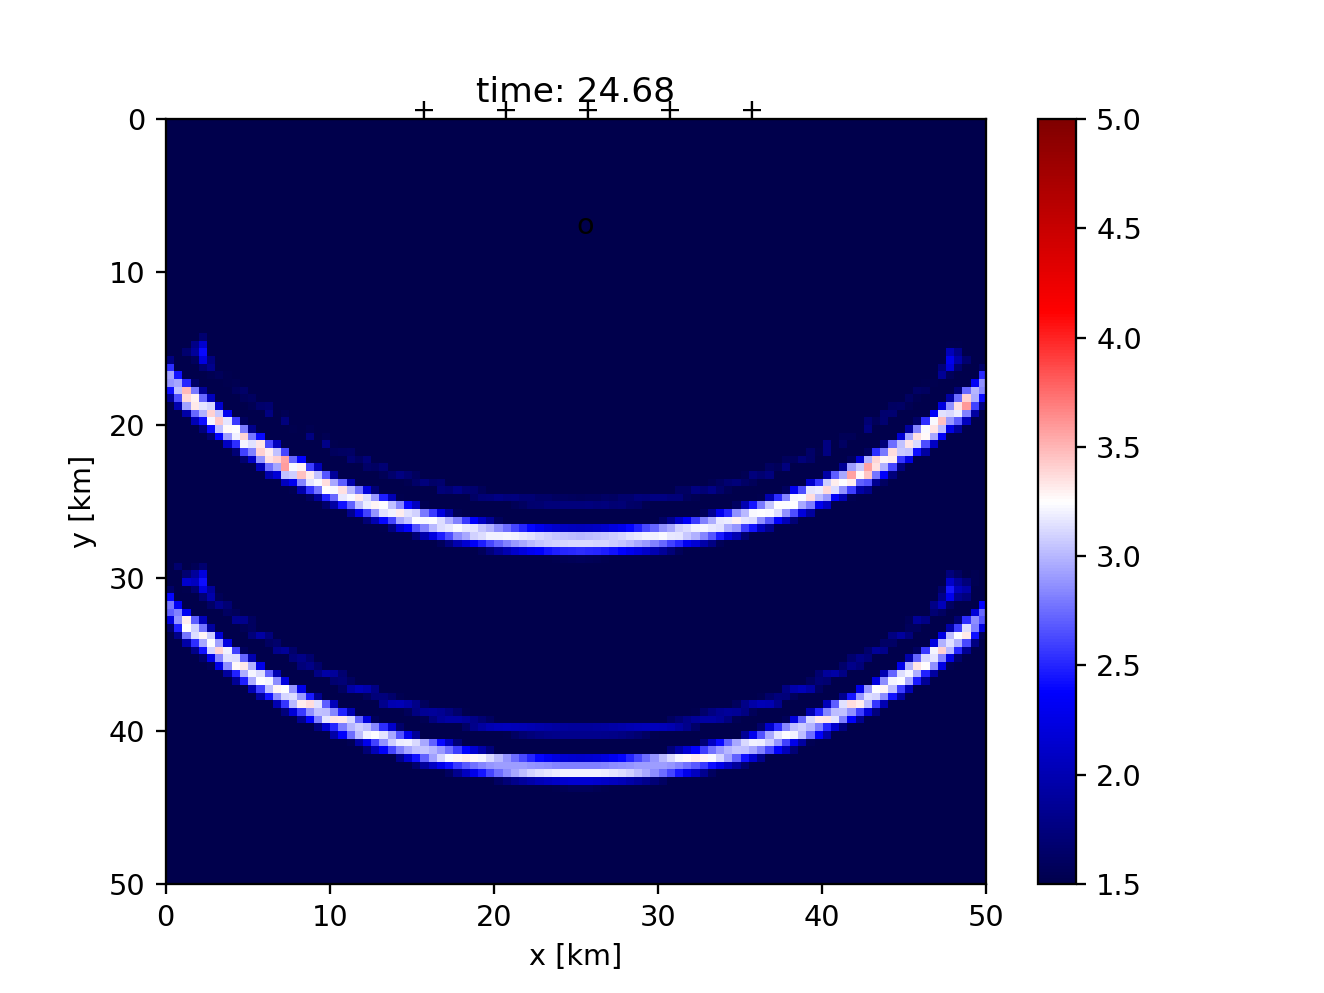

<IPython.core.display.Javascript object>


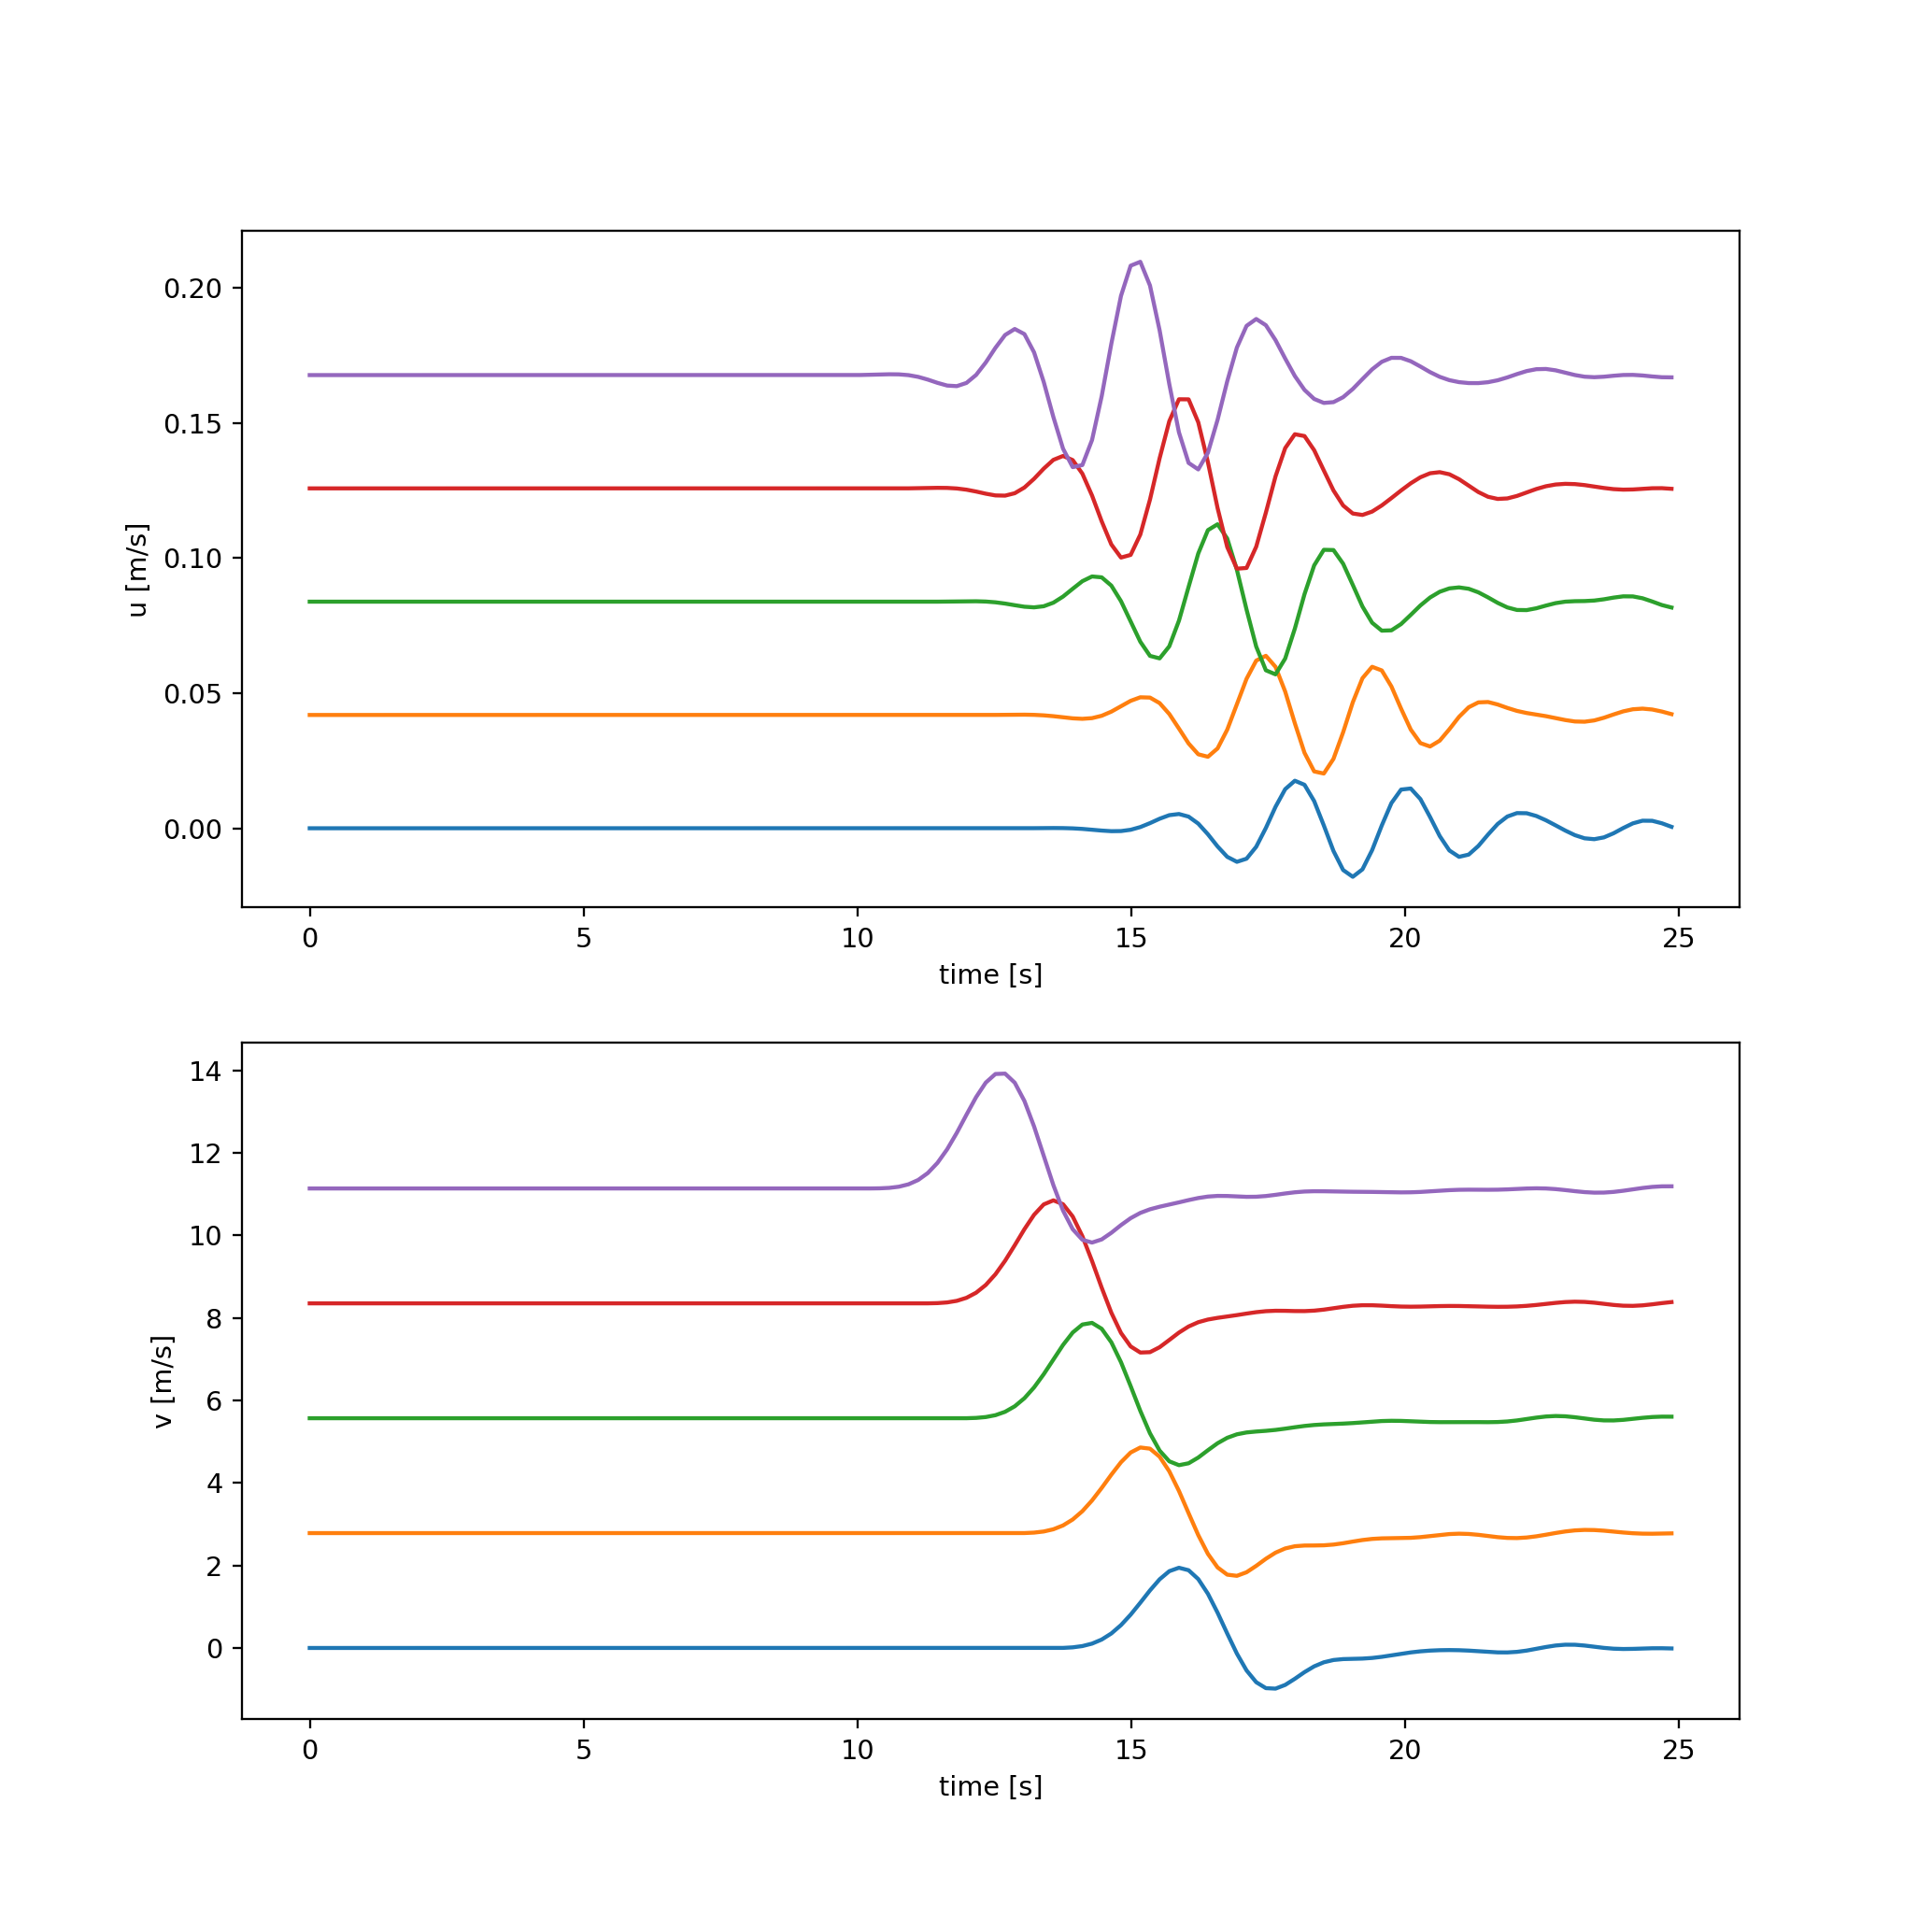

In [3]:
# Simulation
# initialize plot        
v = 5.0
p = np.sqrt(F[:,:,0]**2)

image = plt.imshow(p.transpose(), aspect='auto',extent=[0,Lx,Ly,0]
          ,cmap = 'seismic', vmin=1.5, vmax=+v, animated=True, 
          interpolation='none')

# Receiver locations
rx = np.array([15, 20, 25, 30, 35])
ry = np.array([0, 0, 0, 0, 0])

irx = np.array([15, 20, 25, 30, 35])
iry = np.array([0, 0, 0, 0, 0])

for i in range(len(rx)):
    irx[i] = (np.ceil(rx[i]*dx))
    iry[i] = (np.ceil(ry[i]*dy))
    
    

seisvx = np.zeros((len(irx), nt))
seisvy = np.zeros((len(irx), nt))


# Plot the receivers
for x, z in zip(rx, ry):
    plt.text(x, z, '+')

plt.text(x0, y0, 'o')
plt.colorbar()
plt.xlabel('x [km]')
plt.ylabel('y [km]')

plt.show()


# Boundary reflection coefficients
r = np.array([0.,0.,1.,0.])


# required for seismograms
ir = np.arange(len(irx))


# Time-stepping 
for it in range(nt):
    
    t = it*dt
    
    #4th order Runge-Kutta 
    RK4_2D.acoustics_RK4_2D(F, F, Mat, X, Y, t, nf, Nx, Ny, dx, dy, dt, order, r, source_parameter)
    
    #extract absolute pressure fields for visualization
    p = np.sqrt(F[:,:,0]**2)

    # update time
    t = it*dt
    
    # Plot every isnap-th iteration
    if it % isnap == 0:                    # you can change the speed of the plot by increasing the plotting interval
        plt.title("time: %.2f" % t)
        image.set_data(p.transpose())
        plt.gcf().canvas.draw()
        #plt.show()
        #print(it)
    
    # Save seismograms
    seisvx[ir, it] = F[(irx[ir]), (iry[ir]), 1]
    seisvy[ir, it] = F[(irx[ir]), (iry[ir]), 2]
    
plt.ioff()
plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(211)
ymax = seisvx.ravel().max()
time = np.arange(nt) * dt
for ir in range(len(seisvx)):
    plt.plot(time, seisvx[ir, :] + ymax * ir)
    plt.xlabel('time [s]')
    plt.ylabel('u [m/s]')

plt.subplot(212)
ymax = seisvy.ravel().max()
for ir in range(len(seisvy)):
    plt.plot(time, seisvy[ir, :] + ymax * ir)
    plt.xlabel('time [s]')
    plt.ylabel('v [m/s]')

plt.show()


